<a href="https://www.kaggle.com/code/sardorwwe/spaceship-titanic1?scriptVersionId=160148677" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
train['Destination'].value_counts()

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [8]:

def clean_data(df):
    # Rename column names
    df.rename(columns={'PassengerId': 'passenger_id', 'HomePlanet': 'home_planet', 'CryoSleep': 'cryo_sleep', 'Cabin': 'cabin', 'Destination': 'destination', 'Age': 'age',
           'VIP': 'vip', 'RoomService': 'room_service', 'FoodCourt': 'food_court', 'ShoppingMall': 'shopping_mall', 'Spa': 'spa', 'VRDeck': 'vr_deck',
           'Name': 'name', 'Transported': 'transported'}, inplace=True)
    
    # Fill missing values
    df["home_planet"].fillna(df["home_planet"].mode()[0], inplace=True)
    df["cryo_sleep"].fillna(df["cryo_sleep"].mode()[0], inplace=True)
    df["cabin"].fillna(df["cabin"].mode()[0], inplace=True)
    df["destination"].fillna(df["destination"].mode()[0], inplace=True)
    df["vip"].fillna(df["vip"].mode()[0], inplace=True)
    
    df["age"].fillna(df["age"].median(), inplace= True)
    df["room_service"].fillna(df["room_service"].median(), inplace= True)
    df["food_court"].fillna(df["food_court"].median(), inplace= True) 
    df["shopping_mall"].fillna(df["shopping_mall"].median(), inplace= True)
    df["spa"].fillna(df["spa"].median(), inplace= True)
    df["vr_deck"].fillna(df["vr_deck"].median(), inplace= True) 
    
    # Split "cabin" column into "deck", "num", and "side" columns
    df[["deck", "num", "side"]] = df["cabin"].str.split("/", expand=True)
    df.drop(columns=["cabin", "name"], inplace=True)

    # Convert categorical values to numerical using LabelEncoder
    le = LabelEncoder()
    df["home_planet"] = le.fit_transform(df["home_planet"].values)
    df["cryo_sleep"] = le.fit_transform(df["cryo_sleep"].values)
    df["destination"] = le.fit_transform(df["destination"].values)
    df["vip"] = le.fit_transform(df["vip"].values)
    df["deck"] = le.fit_transform(df["deck"].values)
    df["num"] = le.fit_transform(df["num"].values)
    df["side"] = le.fit_transform(df["side"].values)

    # Convert data types
    df["age"] = df["age"].astype(int)
    df["room_service"] = df["room_service"].astype(int)
    df["food_court"] = df["food_court"].astype(int)
    df["shopping_mall"] = df["shopping_mall"].astype(int)
    df["spa"] = df["spa"].astype(int)
    df["vr_deck"] = df["vr_deck"].astype(int)
    
    return df

In [9]:
# Ma'lumotlarni tozalash
train_df = clean_data(train)
test_df = clean_data(test)

In [10]:
train_df.head()

,passenger_id,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,transported,deck,num,side
0,0001_01,1,0,2,39,0,0,0,0,0,0,False,1,0,0
1,0002_01,0,0,2,24,0,109,9,25,549,44,True,5,0,1
2,0003_01,1,0,2,58,1,43,3576,0,6715,49,False,0,0,1
3,0003_02,1,0,2,33,0,0,1283,371,3329,193,False,0,0,1
4,0004_01,0,0,2,16,0,303,70,151,565,2,True,5,1,1


In [11]:
train_df.corrwith(train_df["transported"]).abs().sort_values(ascending=False)

transported      1.000000
cryo_sleep       0.460132
room_service     0.241124
spa              0.218545
vr_deck          0.204874
home_planet      0.115461
deck             0.113992
destination      0.108152
side             0.101397
age              0.074233
food_court       0.045583
vip              0.037261
passenger_id     0.021491
num              0.019393
shopping_mall    0.009391
dtype: float64

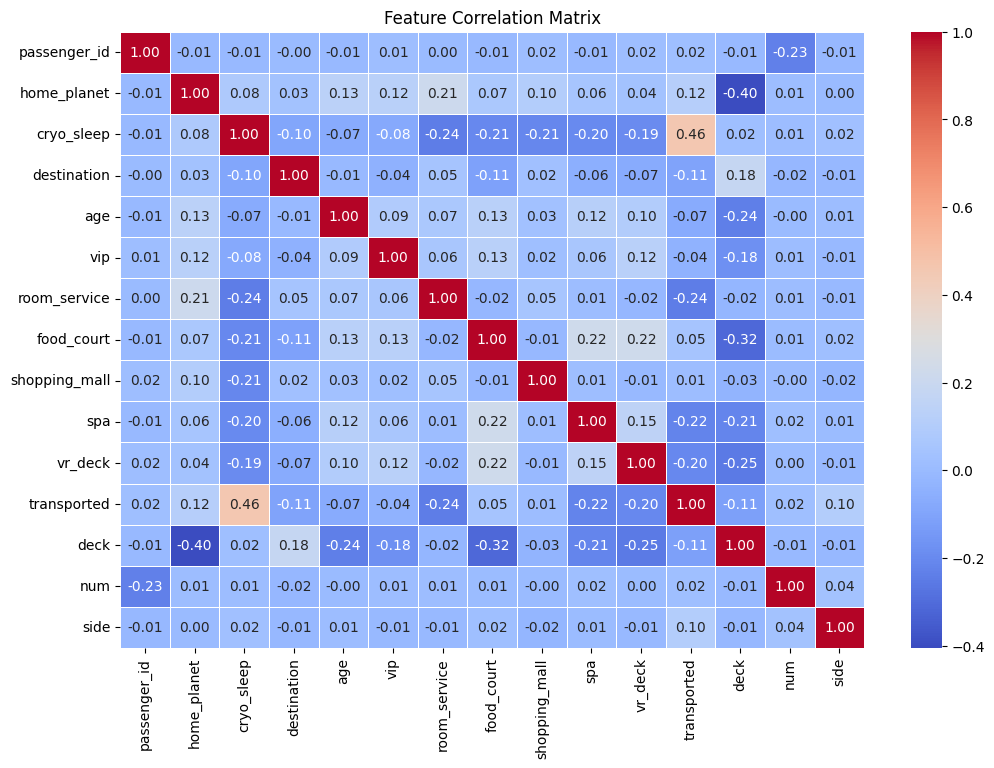

In [12]:
# Korrelatsiya tahlili
correlation = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

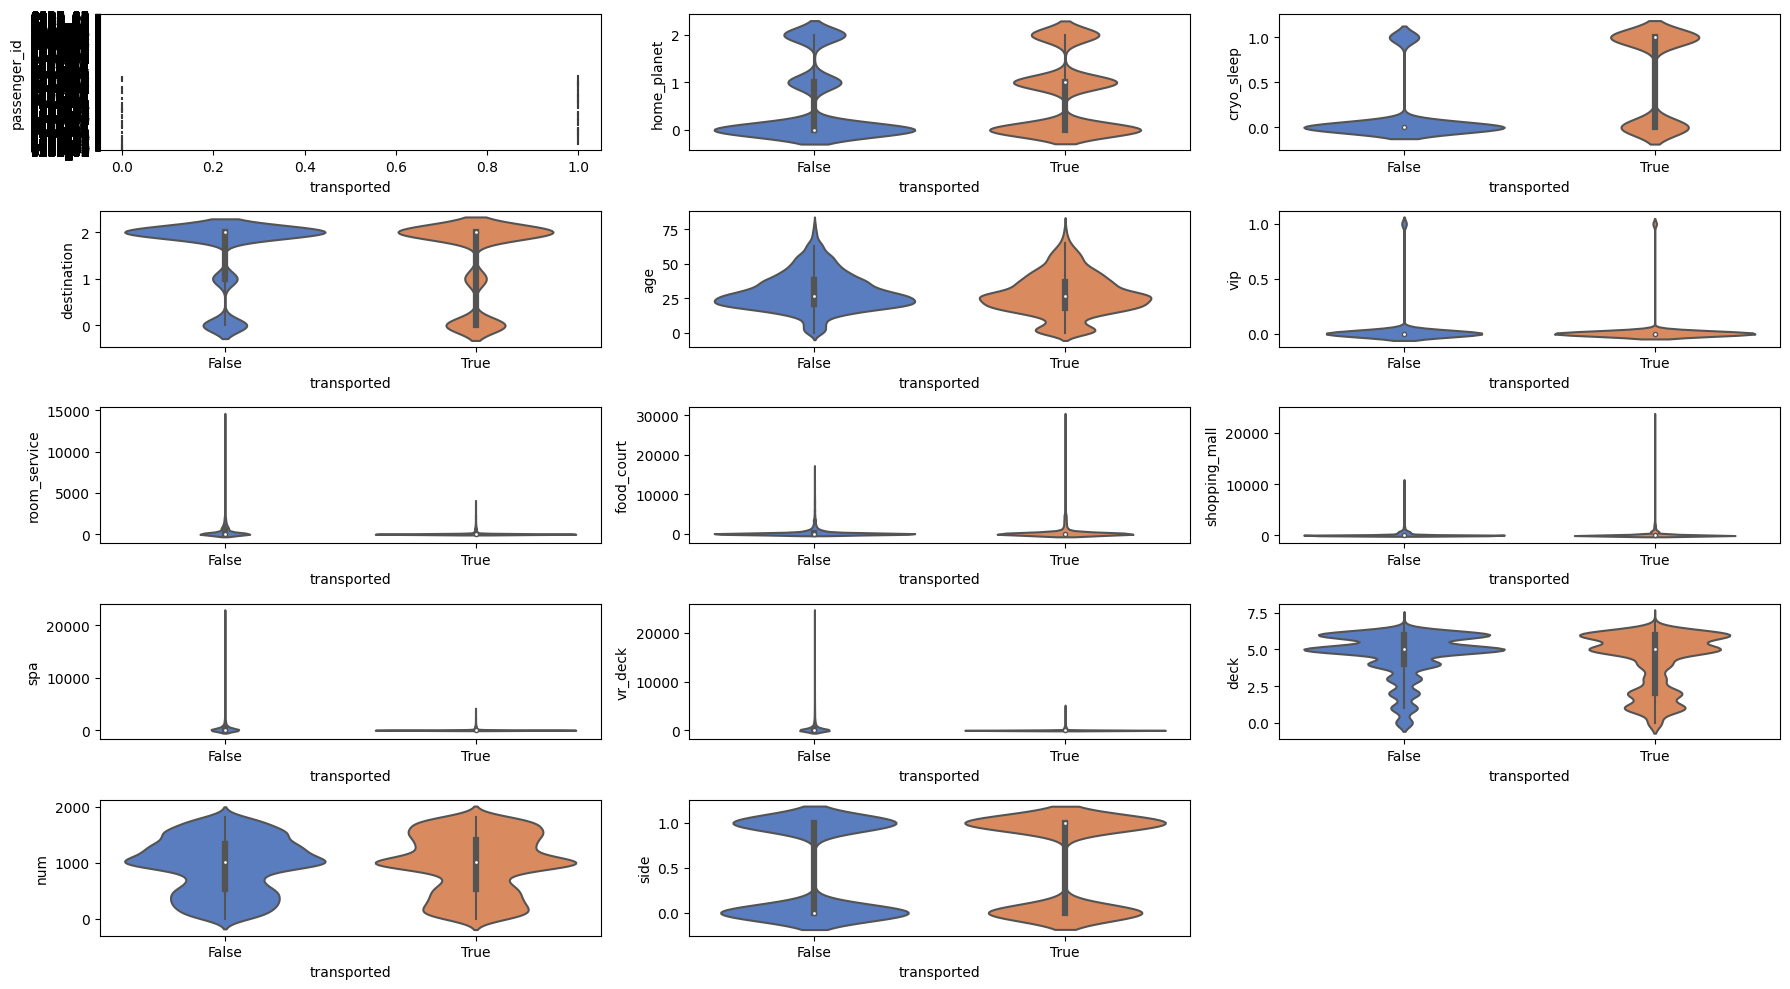

In [13]:
# Violine Plots
features = train_df.columns.drop('transported')
num_features = len(features)
rows = (num_features // 3) + (num_features % 3 > 0)  # Qatlamalar sonini hisoblash

plt.figure(figsize=(18, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(rows, 3, i)
    sns.violinplot(x='transported', y=feature, data=train_df, palette='muted')
plt.tight_layout()
plt.show()

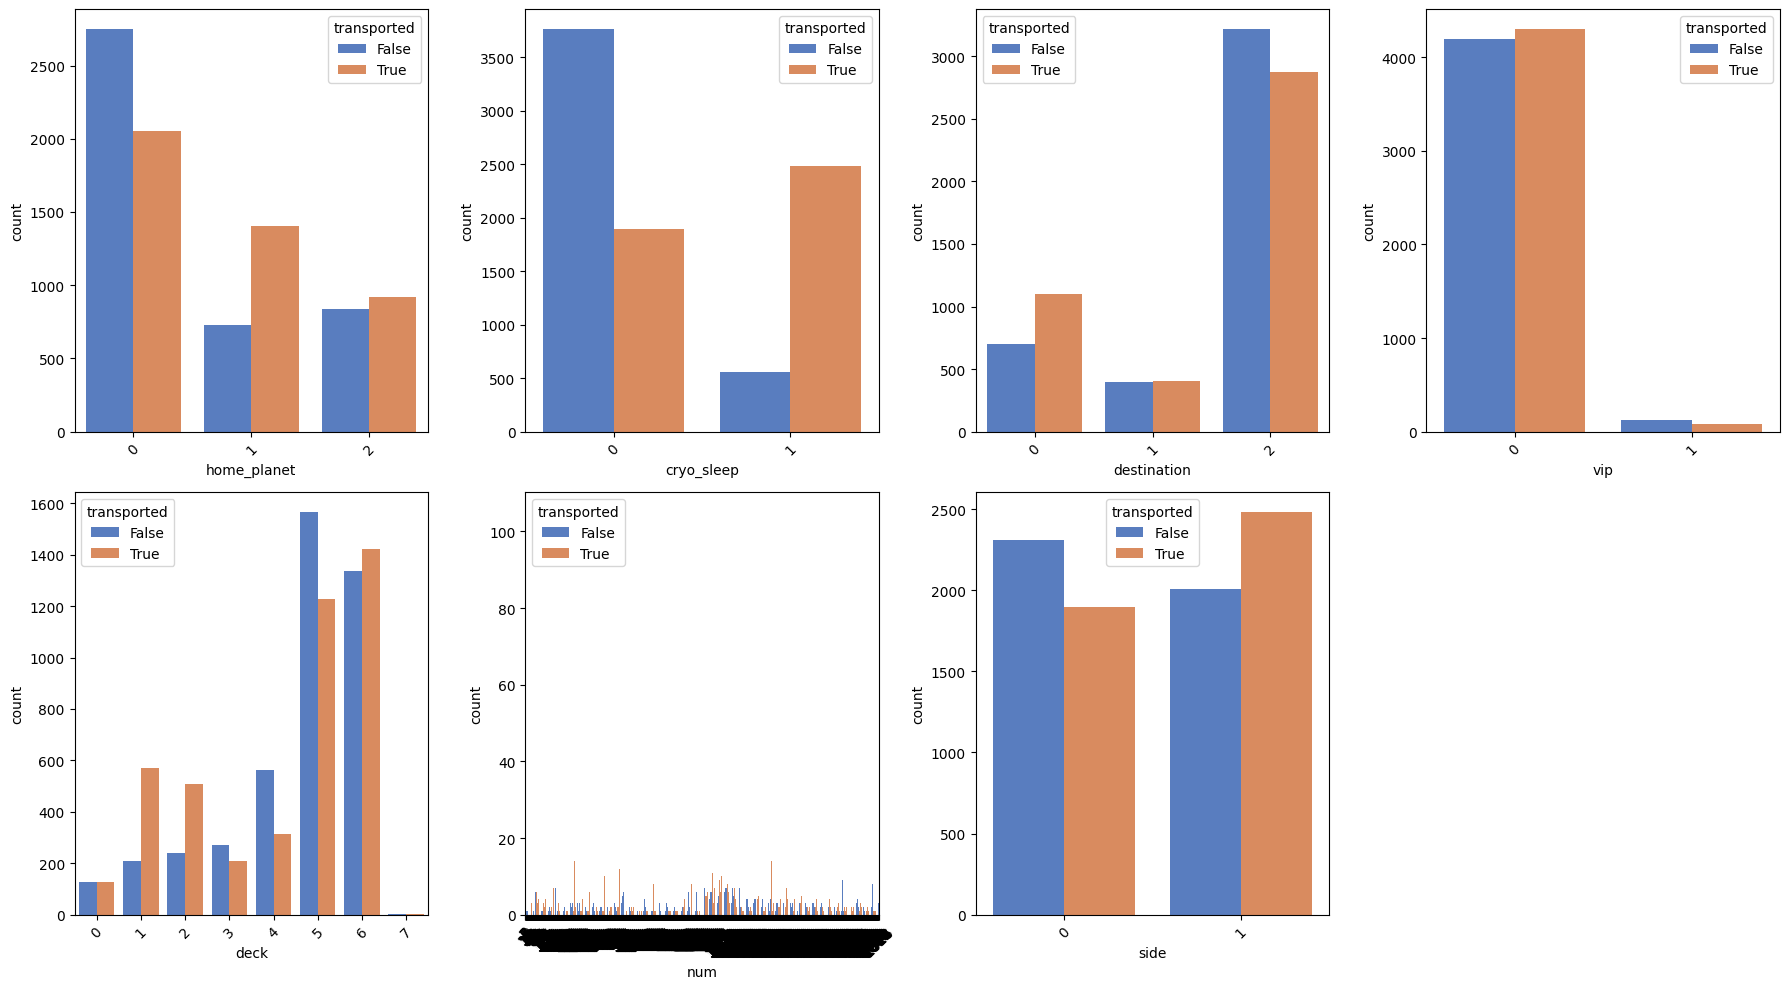

In [14]:
# Kategorial o'zgaruvchilar tahlili
categorical_features = ['home_planet', 'cryo_sleep', 'destination', 'vip', 'deck', 'num', 'side']
plt.figure(figsize=(18, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, hue='transported', data=train_df, palette='muted')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# StandardScaler obyekti yaratish
scaler = StandardScaler()

# Ma'lumotlarni standart qiymatga olib kelish
scaled_data = scaler.fit_transform(train_df)

# Train_test_set


In [16]:
X = train_df.drop(columns=["transported"])
y = train_df["transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [18]:

# Tahlil natijalari
y_predict = rf_model.predict(X_test)

Accuracy: 0.7924094307073031
Confusion Matrix:
[[694 167]
 [194 684]]


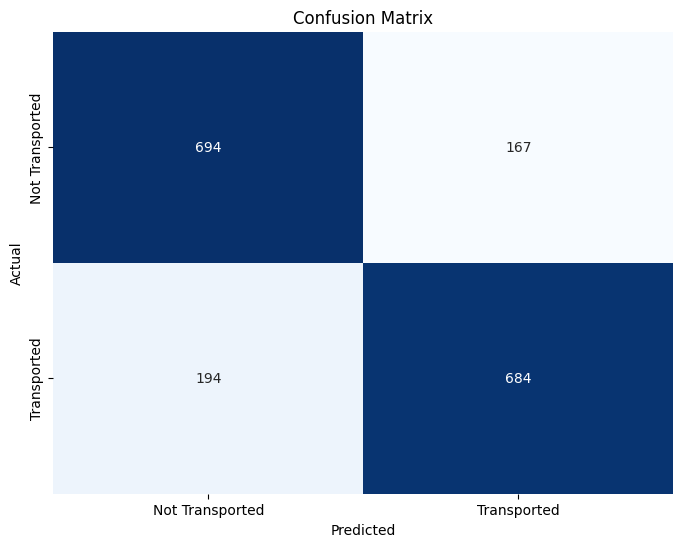

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.81      0.79       861
        True       0.80      0.78      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [19]:
# Accuracy
accuracy = accuracy_score(y_test, y_predict)
print(f"Accuracy: {accuracy}")

# Confusion matrix
conf_matrix1 = confusion_matrix(y_test, y_predict)
print(f"Confusion Matrix:\n{conf_matrix1}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Not Transported", "Transported"],
            yticklabels=["Not Transported", "Transported"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_predict)
print(f"Classification Report:\n{class_report}")


In [20]:

# Model accuracy
print(f"Model accuracy: {accuracy:.2%}")

Model accuracy: 79.24%


In [21]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [22]:
test.head()

,passenger_id,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vr_deck,deck,num,side
0,0013_01,0,1,2,27,0,0,0,0,0,0,6,820,1
1,0018_01,0,0,2,19,0,0,9,0,2823,0,5,927,1
2,0019_01,1,1,0,31,0,0,0,0,0,0,2,0,1
3,0021_01,1,0,2,38,0,0,6652,0,181,585,2,1,1
4,0023_01,0,0,2,20,0,10,0,635,0,0,5,1029,1


In [23]:
# Test ma'lumotlarini olish
X_test_submission = test_df

# Modelni test qilish
y_pred_submission = rf_model.predict(X_test_submission)

# Submission faylga ma'lumotlarni yozish
submission_data = pd.DataFrame({'PassengerId': test_df['passenger_id'], 'Transported': y_pred_submission})
submission_data.to_csv('submission1.csv', index=False)


In [24]:
submission.head(50)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
5,0027_01,False
6,0029_01,False
7,0032_01,False
8,0032_02,False
9,0033_01,False
